#### Value at Risk and Conditional Value at Risk Engine Overview

In this project, I explore the different methods of calculating VaR and CVaR.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t
from scipy.stats import gaussian_kde

In the cell below I am pulling the data from the csv I created, and doing calculations for log returns, covariance matrix, portfolio weights, variance, and standard deviation.

In [3]:
# Load prices from adj close prices csv and computing log returns
prices = pd.read_csv("adj_close_prices.csv", parse_dates=["Date"], index_col="Date").sort_index()

log_returns = np.log(prices / prices.shift(1)).dropna()

# Compute covariance matrix
cov_matrix = log_returns.cov()

# Generating portfolio weights
weights = np.array([1/6]*6)

# Calculating variance
variance = weights.T @ cov_matrix @weights

# Calculating standard deviation
std_dev = np.sqrt(variance)

hist_returns = (log_returns * weights).sum(axis=1)

### Historical Value at Risk
The basis of Historical Value at Risk is based off of a confidence level eg. 95%, a holding period, and then identifying a corresponding loss amount. This represents the probability of not exceeding the potential loss amount we identified, where the holding period is the time during which the risk is being estimated.

An advantage of the historical method is simplicity of calculation since it doesn't require any assumptions and uses real historical events.

Limitations would be that we are assuming that history is going to repeat itself, which is not a particularly strong assumption. For example, in extreme events like the COVID crisis and the 2008 crisis, it cannot be reliable.

The Value at Risk using Historical Method at 0.95% is 29973.80


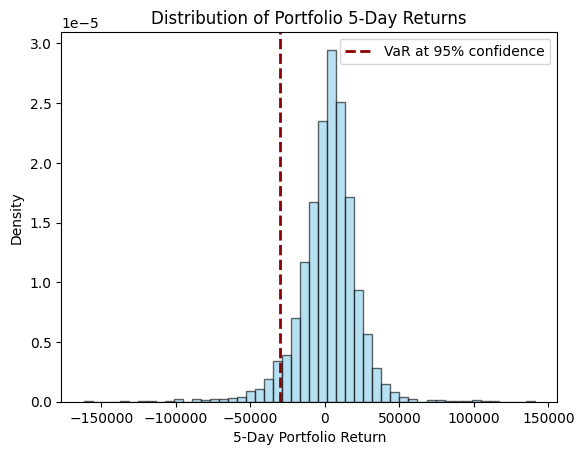

np.float64(29973.797748944755)

In [ ]:
# Historical VaR
def Historical_VaR(portfolio_value, confidence, lookback_days=5, plot=False):
    
    range_returns = log_returns.rolling(window=lookback_days).sum()
    
    range_returns = range_returns.dropna()
    
    portfolio_returns = range_returns.dot(weights)
    
    percentile = (1 - confidence) * 100 
    
    VaR = -np.percentile(portfolio_returns, percentile) * portfolio_value
    
    print(f'The Value at Risk using Historical Method at {confidence}% is {VaR:.02f}')
    if plot:

        # Convert to portfolio value terms
        range_returns_total = portfolio_returns * portfolio_value

        # Histogram (normalized to probability density)
        plt.hist(range_returns_total, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black')

        # VaR line
        plt.axvline(-VaR, color='darkred', linestyle='dashed', linewidth=2, 
                    label=f'VaR at {confidence:.0%} confidence')
        
        plt.xlabel(f"{lookback_days}-Day Portfolio Return")
        plt.ylabel("Density")
        plt.title(f"Distribution of Portfolio {lookback_days}-Day Returns")
        plt.legend()
        plt.show()

    return VaR
Historical_VaR(1000000, .95, plot=True)


### Parametric Value at Risk

Parametric Value at Risk requires an expected return and the standard deviation, and it assumes returns are normally distributed. It is similar to the historical data but it uses a familiar curve instead of the actual data.

An advantage of this method is that we can see where the worst 5% or 1% lie on the curve.

A disadvantage of the parametric method is that, since we assume a normal distribution, it disregards possible fat tails of risk.


The Value at Risk using Parametric Method under normal distribution at 0.95% is  16220.66


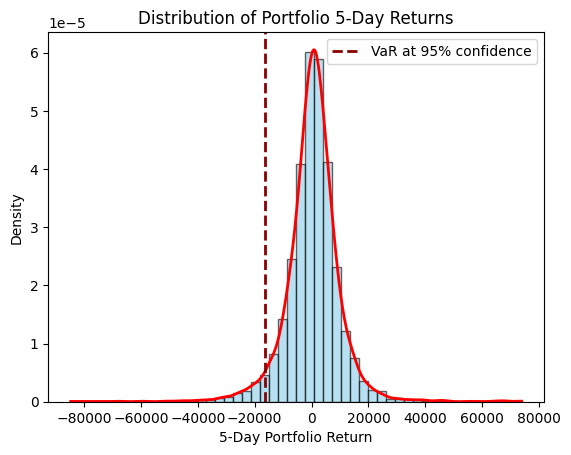

np.float64(16220.664785665607)

In [12]:
# Parametric (Normal) VaR
def Parametric_VaR(portfolio_returns, portfolio_value, confidence, lookback_days, plot=False):
    hist_xday_returns = portfolio_returns.rolling(window=lookback_days).sum()
    z_score = norm.ppf(1-confidence)
    VaR = portfolio_value * std_dev * -z_score

    print(f'The Value at Risk using Parametric Method under normal distribution at {confidence}% is {VaR: .02f}')

    if plot:
        # Convert to portfolio value terms
        range_returns_total = portfolio_returns * portfolio_value

        # Histogram (normalized to probability density)
        plt.hist(range_returns_total, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black')

        # KDE curve
        kde = gaussian_kde(range_returns_total)
        x_vals = np.linspace(range_returns_total.min(), range_returns_total.max(), 500)
        y_vals = kde(x_vals)
        plt.plot(x_vals, y_vals, color='red', linewidth=2)

        # VaR line
        plt.axvline(-VaR, color='darkred', linestyle='dashed', linewidth=2, label=f'VaR at {confidence:.0%} confidence')
        
        plt.xlabel(f"{lookback_days}-Day Portfolio Return")
        plt.ylabel("Density")
        plt.title(f"Distribution of Portfolio {lookback_days}-Day Returns")
        plt.legend()
        plt.show()
    return VaR
Parametric_VaR(hist_returns, 1000000, .95, 5, True)


### Monte Carlo Value at Risk

The 

The Value at Risk using multivariate-normal Monte Carlo at 95% is 34119.38


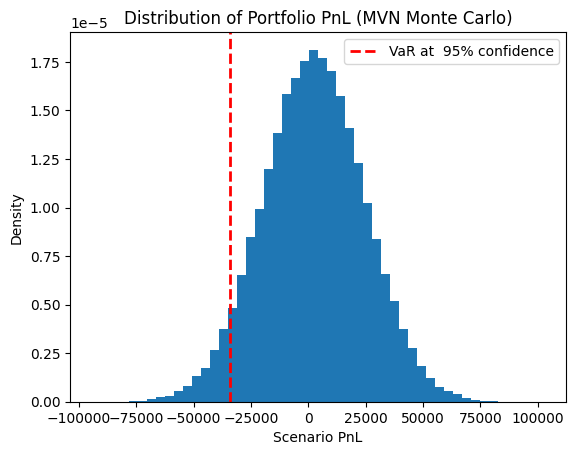

np.float64(34119.38013921404)

In [18]:
def portfolio_pnl(portfolio_value, days, expected_returns, z_score, std_dev):
    return portfolio_value * expected_returns * days + portfolio_value * std_dev * z_score * np.sqrt(days)

def Monte_Carlo_VaR(portfolio_value, days, simulations, confidence, plot):
    # Ensure array shapes
    p_weights = np.asarray(weights).reshape(-1)

    # Daily asset means & covariance (must be DAILY, not annualized)
    mu_vec = log_returns.mean().values
    Sigma  = log_returns.cov().values

    # Portfolio daily mean and sigma (std_dev should be DAILY portfolio sigma)
    mu_p = float(mu_vec @ p_weights)
    sigma_p = float(std_dev)

    # Draw multivariate normal asset returns
    # Fallback to near-PSD if covariance is not numerically PD
    try:
        R = np.random.multivariate_normal(mean=mu_vec, cov=Sigma, size=simulations)  # (simulations, n_assets)
    except np.linalg.LinAlgError:
        eigvals, eigvecs = np.linalg.eigh(Sigma)
        eigvals = np.clip(eigvals, a_min=0.0, a_max=None)
        Sigma_psd = eigvecs @ np.diag(eigvals) @ eigvecs.T
        R = np.random.multivariate_normal(mean=mu_vec, cov=Sigma_psd, size=simulations)

    # Collapse to portfolio daily returns
    rp_daily = R @ p_weights  # shape (simulations,)

    # Convert each sampled portfolio return to a z-score relative to (mu_p, sigma_p)
    z_scores = (rp_daily - mu_p) / sigma_p

    # Reuse your existing PnL structure (vectorized)
    scenario_returns = portfolio_value * (mu_p * days + sigma_p * z_scores * np.sqrt(days))

    # VaR
    VaR = -np.percentile(scenario_returns, 100 * (1 - confidence))

    print(f'The Value at Risk using multivariate-normal Monte Carlo at {confidence:.0%} is {VaR:.02f}')
    if plot:
        plt.hist(scenario_returns, bins=50, density=True)
        plt.xlabel('Scenario PnL')
        plt.ylabel('Density')
        plt.title('Distribution of Portfolio PnL (MVN Monte Carlo)')
        plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2,
                    label=f'VaR at {confidence: .0%} confidence')
        plt.legend()
        plt.show()

    return VaR

Monte_Carlo_VaR(1000000, 5, 100000, .95, True)

# 33989.69

### Implementing Conditional Value at Risk for different methods

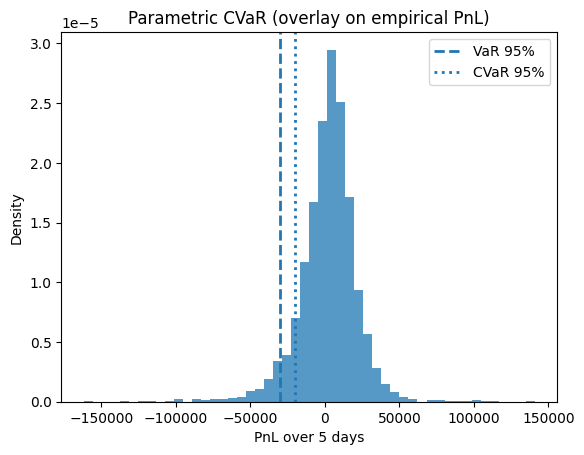

20341.36804117239


In [19]:
def Parametric_CVaR(portfolio_returns, portfolio_value, confidence, lookback_days, plot=False):
    
    hist_xday_returns = portfolio_returns.rolling(window=lookback_days).sum()
    z_score = norm.ppf(1-confidence)
    VaR = portfolio_value * std_dev * -z_score

    # PDF of the z score
    pdf_z = norm.pdf(z_score)

    CVaR = portfolio_value * std_dev * (pdf_z / (1-confidence))
    
    pnl = portfolio_returns.rolling(lookback_days).sum().dropna() * portfolio_value
    cutoff_pnl = np.percentile(pnl, 100 * (1 - confidence))
    if len(pnl) == 0:
        raise ValueError("Not enough data to build a rolling histogram for the chosen lookback_days.")

    if plot:
        plt.hist(pnl, bins=50, density=True, alpha=0.75)
        plt.axvline(cutoff_pnl, linestyle='dashed', linewidth=2, label=f'VaR {confidence:.0%}')
        plt.axvline(-CVaR, linestyle=':', linewidth=2, label=f'CVaR {confidence:.0%}')
        plt.xlabel(f"PnL over {lookback_days} days")
        plt.ylabel("Density")
        plt.title("Parametric CVaR (overlay on empirical PnL)")
        plt.legend()
        plt.show()


    return CVaR
print(Parametric_CVaR(hist_returns, 1000000, .95, 5, True))

The Conditional Value at Risk using Monte Carlo at 0.95% is 42843.15691127514, and VaR is 33682.72822756686


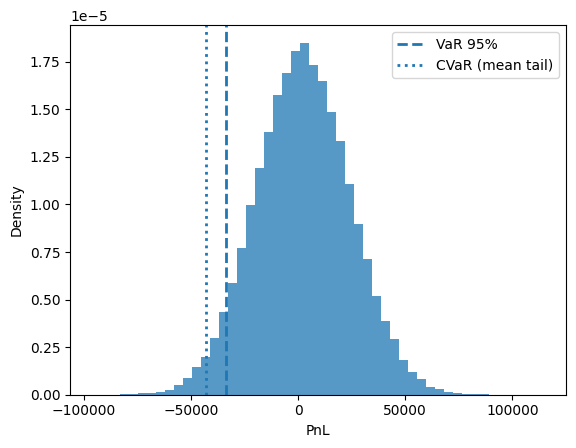

np.float64(42843.15691127514)

In [22]:
def Monte_Carlo_CVaR(portfolio_value, days, simulations, confidence, plot):
    
    expected_returns = np.sum(log_returns.mean() * weights)

    scenario_returns = []
    for _ in range(simulations):
        z_score = np.random.normal(0, 1)
        scenario_returns.append(
            portfolio_pnl(portfolio_value, days, expected_returns, z_score, std_dev)
        )

    # Convert to array
    pnl = np.asarray(scenario_returns)
    cutoff_pnl = np.percentile(pnl, 100 * (1 - confidence))  # this is negative PnL

    # VaR
    VaR = -cutoff_pnl

    # CVaR / Expected Shortfall = average loss beyond VaR
    tail = pnl[pnl <= cutoff_pnl]        # still negative PnL
    CVaR = -tail.mean()                  # make it a positive loss
    
    print(f'The Conditional Value at Risk using Monte Carlo at {confidence}% is {CVaR}, and VaR is {VaR}')

    if plot:
        plt.hist(pnl, bins=50, density=True, alpha=0.75)
        plt.axvline(cutoff_pnl, linestyle='dashed', linewidth=2, label=f'VaR {confidence:.0%}')
        plt.axvline(tail.mean(), linestyle='dotted', linewidth=2, label='CVaR (mean tail)')
        plt.xlabel("PnL")
        plt.ylabel("Density")
        plt.legend()
        plt.show()
    
    return CVaR

Monte_Carlo_CVaR(1000000, 5, 100000, .95, True)

In [9]:
def backtester(horizon, confidence, window, return_series):

IndentationError: expected an indented block (343688393.py, line 1)